In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
import deepchem as dc
from deepchem.molnet import load_qm7, load_qm7_from_mat
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import Draw, rdDepictor
from IPython.display import SVG

from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

%matplotlib inline

### Load data set 


In [62]:
dataset_file = "raw_data/gdb7.sdf"

qm7_tasks = ["u0_atom"]

featurizer = dc.feat.CoulombMatrix(max_atoms=23)

loader = dc.data.SDFLoader(
  tasks=['u0_atom'],
  smiles_field="smiles",
  mol_field="mol",
  featurizer=featurizer)

dataset = loader.featurize(dataset_file)

Loading raw samples now.
shard_size: 8192
Reading structures from raw_data/gdb7.sdf.
Currently featurizing feature_type: CoulombMatrix
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 4.162 s
TIMING: dataset construction took 6.074 s
Loading dataset from disk.


In [63]:
dataset.get_shape()

((7165, 23, 23), (7165, 1), (7165, 1), (7165,))

In [140]:
splitter = dc.splits.SingletaskStratifiedSplitter(task_number=0)

train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

print(train_dataset.get_shape())
print(valid_dataset.get_shape())
print(test_dataset.get_shape())

TIMING: dataset construction took 0.431 s
Loading dataset from disk.
TIMING: dataset construction took 0.191 s
Loading dataset from disk.
TIMING: dataset construction took 0.190 s
Loading dataset from disk.
((5728, 23, 23), (5728, 1), (5728, 1), (5728,))
((716, 23, 23), (716, 1), (716, 1), (716,))
((716, 23, 23), (716, 1), (716, 1), (716,))


In [141]:
## Dataset analysis

mols = {}

for name,data in zip(['train', 'valid', 'test'],[train_dataset, valid_dataset, test_dataset]):
    print(name, data.get_shape())
    #highest atomisation energy
    ys = np.argsort(data.y, axis=None)
    #lowest atomisation energy
    low_ys = ys[-10:]
    #sorted_data = data.y[ys]
    mols[name] = {'high': [Chem.MolFromSmiles(id_) for id_ in data.ids[ys]],
                  'low': [Chem.MolFromSmiles(id_) for id_ in data.ids[low_ys]]}
# mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
# Chem.Draw.MolsToGridImage(mol_list,legends=[mol.GetProp('_Name') for mol in mol_list])


train ((5728, 23, 23), (5728, 1), (5728, 1), (5728,))
valid ((716, 23, 23), (716, 1), (716, 1), (716,))
test ((716, 23, 23), (716, 1), (716, 1), (716,))


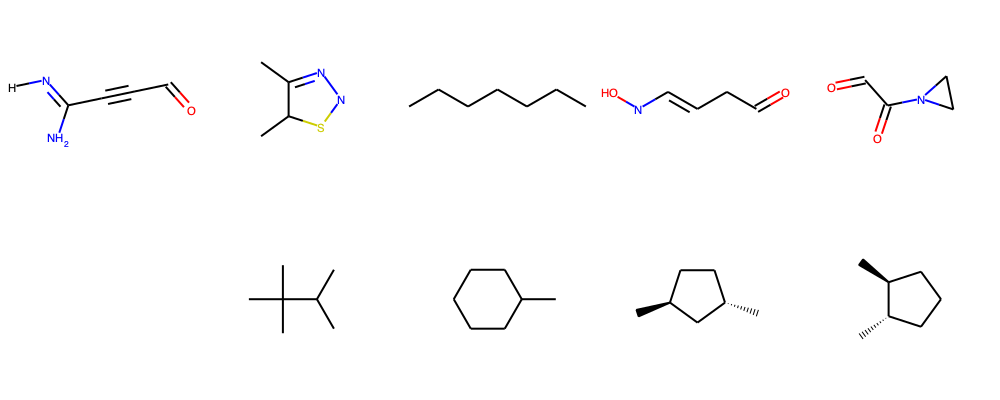

In [142]:
## Draw chemical structures
Chem.Draw.MolsToGridImage(mols['train']['high'][:10], molsPerRow=5) #, legends=[mol.GetProp('_Name') for mol in mols['train'][:10]])
#Chem.Draw.MolsToGridImage(mols['train']['low'][:10], molsPerRow=5) #, legends=[mol.GetProp('_Name') for mol in mols['train'][:10]])


In [138]:
## Get bond types
m = Chem.MolFromSmiles('C1OC1')
print(m.GetBonds()[0].GetBondType())

SINGLE


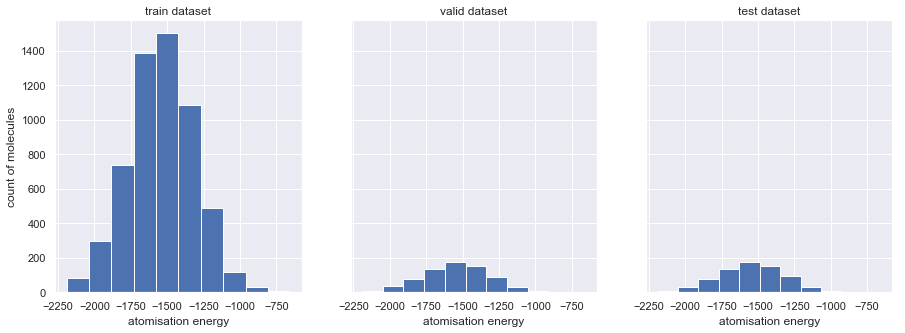

In [129]:
## Distribution of atomisation energy 

fix, ax = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)
ax[0].hist(train_dataset.y)
plt.title("Histogram of atomisation energies")
ax[0].set_title("train dataset")
ax[0].set_xlabel("atomisation energy")
ax[0].set_ylabel("count of molecules")
ax[1].hist(valid_dataset.y)
ax[1].set_title("valid dataset")
ax[1].set_xlabel("atomisation energy")
ax[2].hist(test_dataset.y)
ax[2].set_title("test dataset")
ax[2].set_xlabel("atomisation energy")
# plt.ylabel("number of molecules")
#plt.title("Histogram of atomisation energies")
plt.show()

In [139]:
train_dataset

In [143]:
## Binarisation
## Default params: step = 1.0, noise = 1.0

coloumb_transformer = dc.trans.CoulombFitTransformer(dataset=train_dataset)

train_c_trans = coloumb_transformer.transform(train_dataset)
valid_c_trans = coloumb_transformer.transform(valid_dataset)
test_c_trans = coloumb_transformer.transform(test_dataset)


TIMING: dataset construction took 2.235 s
Loading dataset from disk.
TIMING: dataset construction took 0.282 s
Loading dataset from disk.
TIMING: dataset construction took 0.265 s
Loading dataset from disk.


In [144]:
print(train_c_trans.X.shape)
print(valid_c_trans.X.shape)
print(test_c_trans.X.shape)

(5728, 2099)
(716, 2099)
(716, 2099)


## Keras Neural Networks

In [150]:
## Keras implementation 
from tensorflow import keras

## Functions

def plot_history(history, title):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    #fig, ax = plt.subplots(1,2, figsize=(12,6))
    plt.figure(figsize=(8,6))
   # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train MSE')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Valid MSE')
#     plt.plot(hist['epoch'], hist['val_loss'],
#            label = 'Val Loss')
    plt.title(title)
    plt.legend()
    #plt.ylim([0,5])
    #ax[0].legend()
    plt.show()
    

Model parameters and weights inspired by Hansen et al (2015) Journal of Physical Chemistry Letters

Initial weights W0 and learning rates γ are chosen as W0 ∼ N(0, 1/√m) and γ = γ0/√m where m is the number of input units and γ0 is the global learning rate of the network set to γ0 = 0.01. 

In [146]:
# Train on dataset

X_train = train_c_trans.X
y_train = train_c_trans.y

# Validate on dataset

X_valid = valid_c_trans.X
y_valid = valid_c_trans.y

# Initialise weights

init_layer1 = keras.initializers.RandomNormal(mean=0, stddev=(1/np.sqrt(400)))
init_layer2 = keras.initializers.RandomNormal(mean=0, stddev=(1/np.sqrt(100)))
#lr = 0.01/np.sqrt(400)
lr = 0.01

# Network

model = tf.keras.Sequential([
keras.layers.Dense(400, input_shape=(X_train.shape[1],), kernel_initializer=init_layer1, activation='sigmoid'),
keras.layers.Dense(100, activation='sigmoid', kernel_initializer=init_layer2),
#keras.layers.Dense(100, activation='sigmoid'),
keras.layers.Dense(1)])

# Optimizer
sgd = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam()
# Configure a model for mean-squared error regression.
model.compile(optimizer=sgd,
              loss='mae',       # mean squared error
              metrics=['mae', 'mse'])  # mean absolute error

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, mode='min')

# Save model weights checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint('sgd_model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')



In [147]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 400)               840000    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               40100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 880,201
Trainable params: 880,201
Non-trainable params: 0
_________________________________________________________________


In [151]:
# Train model

history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=500, 
                    callbacks=[early_stop], batch_size=25, verbose=0)



Instructions for updating:
Use tf.cast instead.


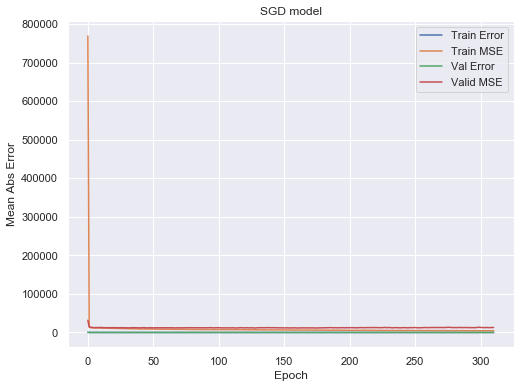

In [152]:
plot_history(history, "SGD model")

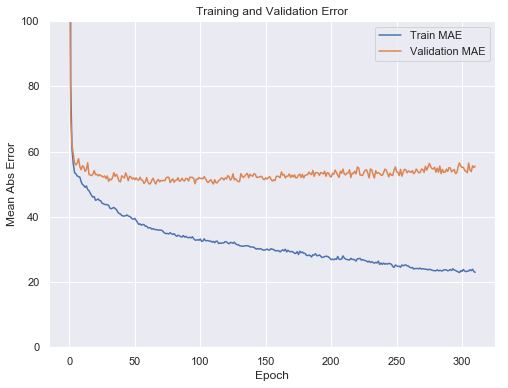

In [153]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

#fig, ax = plt.subplots(1,2, figsize=(12,6))
plt.figure(figsize=(8,6))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.ylim(0,100)
plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train MAE')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label='Validation MAE')
plt.title("Training and Validation Error")
plt.legend()
plt.show()

In [154]:
# Save initial model 

model.save("keras_from_mat_sgd_0.001_400_100_23082019.h5")

In [155]:
## Test dataset

X_test = test_c_trans.X
y_test = test_c_trans.y

shape X_test:  (716, 2099)
shape y_test:  (716, 1)
716/716 [==============================] - 0s 88us/sample - loss: 55.1452 - mean_absolute_error: 55.1451 - mean_squared_error: 12801.1982


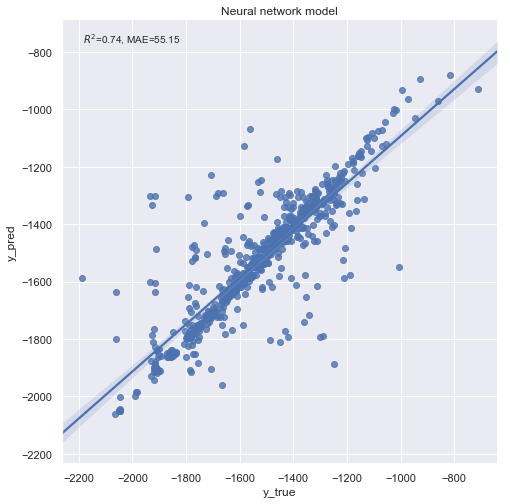

In [156]:
# Test
from sklearn import metrics 

print("shape X_test: ", X_test.shape)
print("shape y_test: ", y_test.shape)

predictions = model.predict(X_test)
scores = model.evaluate(X_test, y_test)
keras_errors = {}

keras_errors['test'] = {'mae': metrics.mean_absolute_error(y_test, predictions), 
                        'mse': np.sqrt(metrics.mean_squared_error(y_test, predictions))}

#keras_errors['test'] = {'mean_squared_error': metrics.mean_squared_error(y_test, predictions)}


# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# ax.bar(['train', 'test'], [train_scores['mean_absolute_error'], test_scores['mean_absolute_error']])
# #ax[1].bar(['mae', 'pearsons_r2'], test_scores)
# plt.title("Kernel ridge regression")
# plt.ylabel("mean absolute error")
# plt.show()

results = pd.DataFrame(predictions, columns = ['y_pred'])
results['y_true'] = y_test
sns.pairplot(results, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
plt.title("Neural network model")
plt.annotate('$R^2$=%.2f, MAE=%.2f' % (metrics.r2_score(y_test, predictions), 
                                       metrics.mean_absolute_error(y_test, predictions)), 
                                    xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()


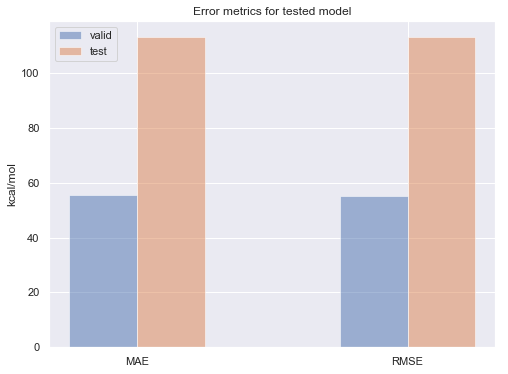

In [157]:
keras_errors['valid'] = {'mae': history.history['val_mean_absolute_error'][-1:].pop(), 
                        'rmse': np.sqrt(history.history['val_mean_squared_error'][-1:].pop())}



pos = list(range(len(keras_errors)))
width = 0.25

fig, ax = plt.subplots(figsize=(8,6))
plt.bar(pos,[keras_errors['valid']['mae'], keras_errors['test']['mae']],width,alpha=0.5, label='mae')
plt.bar([p + 1*width for p in pos], [[keras_errors['valid']['rmse']], keras_errors['test']['mse']], width, 
        alpha=0.5, label='mse')

ax.set_title('Error metrics for tested model')
ax.set_xticks([p + 0.5 * width for p in pos])
ax.set_xticklabels(['MAE', 'RMSE'])
ax.set_ylabel('kcal/mol')

plt.legend(['valid', 'test'], loc='upper left')
plt.show()

## Kernel Ridge Regression 

In [158]:
from sklearn.kernel_ridge import KernelRidge

transformers = [dc.trans.CoulombFitTransformer(dataset=train_dataset)]

params_dict = {
    "kernel": ["laplacian"],
    "alpha": [0.0001],
    "gamma": [0.0001]
}

regression_metric = dc.metrics.Metric(
    dc.metrics.mean_absolute_error, mode="regression")

regressor = KernelRidge(kernel='laplacian', alpha=0.0001, gamma=0.0001)

krr = regressor.fit(X_train, y_train)


## Kernel ridge regression

# def krr_model_builder(params_dict, model_dir):
#     sklearn_model = KernelRidge(**params_dict)
#     return dc.models.SklearnModel(sklearn_model, model_dir)

# optimizer = dc.hyper.HyperparamOpt(krr_model_builder)
# best_krr, best_krr_hyperparams, all_krr_results = optimizer.hyperparam_search(
#     params_dict, train_c_trans, valid_c_trans, transformers,
#     metric=regression_metric)

In [159]:
## Validate model 

valid = krr.predict(X_valid)
test = krr.predict(X_test)
results = pd.DataFrame(valid, columns = ['valid_pred'])
results['test_pred'] = test
results['y_valid'] = y_valid
results['y_test'] = y_test

krr_errors = {}

errors['valid'] = {'mae': metrics.mean_absolute_error(y_valid, valid), 
                   'rmse': np.sqrt(metrics.mean_squared_error(y_valid, valid)), 
                  'r2': metrics.r2_score(y_valid, valid)}
errors['test'] = {'mae': metrics.mean_absolute_error(y_test, test), 
                   'rmse': np.sqrt(metrics.mean_squared_error(y_test, test)),
                 'r2': metrics.r2_score(y_test, test)}


NameError: name 'errors' is not defined

In [ ]:
results.head(4)

In [ ]:
pos = list(range(len(errors)))
width = 0.25

fig, ax = plt.subplots(figsize=(8,6))
plt.bar(pos,[errors['valid']['mae'], errors['test']['mae']],width,alpha=0.5, label='mae')
plt.bar([p + 1*width for p in pos], [[errors['valid']['rmse']], errors['test']['rmse']], width, alpha=0.5, label='rmse')

ax.set_title('Error metrics for tested model')
ax.set_xticks([p + 0.5 * width for p in pos])
ax.set_xticklabels(['MAE', 'RMSE'])
ax.set_ylabel('kcal/mol')

plt.legend(['valid', 'test'], loc='upper left')
plt.show()

sns.pairplot(results, x_vars='y_valid', y_vars='valid_pred', height=7, aspect=1, kind='reg')
plt.title("prediction on validation set")
plt.annotate('$R^2$=%.2f, MAE=%.2f' % (errors['valid']['r2'], errors['valid']['mae']), 
                                    xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()

sns.pairplot(results, x_vars='y_test', y_vars='test_pred', height=7, aspect=1, kind='reg')
plt.title("prediction on test set")
plt.annotate('$R^2$=%.2f, MAE=%.2f' % (errors['test']['r2'], errors['test']['mae']), 
                                    xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()

In [ ]:
import joblib

# save the model to disk
filename = 'krr_binarised_laplacian_23082019.sav'
joblib.dump(krr, open(filename, 'wb'))

# load the model from disk
loaded_model = joblib.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

### DeepChem KRR

In [ ]:
from deepchem.models.tensorgraph.optimizers import ExponentialDecay
from sklearn.kernel_ridge import KernelRidge
tf.set_random_seed(123)

## Kernel ridge regression

def krr_model_builder(model_dir):
    sklearn_model = KernelRidge(kernel='laplacian', alpha=0.0001, gamma=0.0001)
    return dc.models.SklearnModel(sklearn_model, model_dir)

regression_metric = dc.metrics.Metric(
    dc.metrics.mean_absolute_error, mode="regression")

krr = dc.models.SingletaskToMultitask(tasks, krr_model_builder)

# Fit trained model
krr.fit(train_c_trans)
#model.save()


AttributeError: 'numpy.ndarray' object has no attribute 'iterbatches'

In [148]:
#transformers = [dc.trans.CoulombFitTransformer(dataset=train_dataset)]
transformers = [None]

train_evaluator = dc.utils.evaluate.Evaluator(krr, train_c_trans, transformers)
train_scores = train_evaluator.compute_model_performance([regression_metric])

print("Train scores [kcal/mol]")
print(train_scores)

test_evaluator = dc.utils.evaluate.Evaluator(krr, test_c_trans, transformers)
test_scores = test_evaluator.compute_model_performance([regression_metric])

print("Validation scores [kcal/mol]")
print(test_scores)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.bar(['train', 'test'], [train_scores['mean_absolute_error'], test_scores['mean_absolute_error']])
#ax[1].bar(['mae', 'pearsons_r2'], test_scores)
plt.title("Kernel ridge regression")
plt.ylabel("mean absolute error")
plt.show()

AttributeError: 'NoneType' object has no attribute 'transform_y'

## Single task NN 

In [141]:
train_c_trans.X.shape

(5728, 2089)

In [143]:
#from deepchem.molnet import load_qm7_from_mat
from deepchem.models.tensorgraph.optimizers import ExponentialDecay

# qm7_tasks, datasets, transformers = load_qm7_from_mat(
#     split='stratified', move_mean=True, reload=False)


# qm_train, qm_valid, qm_test = datasets

# fit_transformers = [dc.trans.CoulombFitTransformer(qm_train)]

rate = 0.001
dc_model = dc.models.MultitaskFitTransformRegressor(
    n_tasks=1,
    n_features=2089,
    learning_rate=rate,
    momentum=.8,
    batch_size=25,
    weight_init_stddevs=[1 / np.sqrt(400), 1 / np.sqrt(100), 1 / np.sqrt(100)],
    bias_init_consts=[0., 0., 0.],
    layer_sizes=[400, 100, 100],
    dropouts=[0.01, 0.01, 0.01],
    n_evals=10,
    seed=123)

# Fit trained model
dc_model.fit(train_c_trans, nb_epoch=500)

# train_scores = dc_model.evaluate(train_c_trans, metric, transformers)
# valid_scores = dc_model.evaluate(train_c_valid, metric, transformers)


1.13.1


InvalidArgumentError: You must feed a value for placeholder tensor 'input_4' with dtype float and shape [?]
	 [[node input_4 (defined at /Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/deepchem/models/tensorgraph/fcnet.py:221) ]]

Caused by op 'input_4', defined at:
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-143-d1e6e8f7b906>", line 26, in <module>
    seed=123)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/deepchem/models/tensorgraph/fcnet.py", line 346, in __init__
    n_tasks, n_features, batch_size=batch_size, **kwargs)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/deepchem/models/tensorgraph/fcnet.py", line 221, in __init__
    dropout_switch = Input(shape=tuple())
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/keras/engine/input_layer.py", line 231, in Input
    input_tensor=tensor)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/keras/engine/input_layer.py", line 107, in __init__
    name=self.name)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/keras/backend.py", line 876, in placeholder
    x = array_ops.placeholder(dtype, shape=shape, name=name)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 2077, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5791, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_4' with dtype float and shape [?]
	 [[node input_4 (defined at /Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/deepchem/models/tensorgraph/fcnet.py:221) ]]


## DTNN

In [ ]:
# Load QM7 dataset
# tasks, datasets, transformers = dc.molnet.load_qm7_from_mat(move_mean=False)
# train_dataset, valid_dataset, test_dataset = datasets

# Fit models
metric = [
    dc.metrics.Metric(dc.metrics.mean_absolute_error, mode="regression"),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, mode="regression")
]

# Batch size of models
batch_size = 50
n_embedding = 30
n_distance = 51
distance_min = -1.
distance_max = 9.2
n_hidden = 15
rate = 0.001

dtnn_model = dc.models.DTNNModel(
    len(tasks),
    n_embedding=n_embedding,
    n_hidden=n_hidden,
    n_distance=n_distance,
    distance_min=distance_min,
    distance_max=distance_max,
    output_activation=False,
    batch_size=batch_size,
    learning_rate=rate,
    use_queue=False,
    mode="regression")

# Fit trained model
model.fit(train_dataset, nb_epoch=50)

train_scores = model.evaluate(train_dataset, metric, transformers)
valid_scores = model.evaluate(valid_dataset, metric, transformers)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.bar(['train', 'test'], [train_scores['mean_absolute_error'], test_scores['mean_absolute_error']])
#ax[1].bar(['mae', 'pearsons_r2'], test_scores)
plt.title("Deep tensor neural network")
plt.ylabel("mean absolute error")
plt.show()